In [109]:
import os
import torch
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [122]:
from torch.utils.data import Dataset
import os
import torch
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt


class VideoDataset(Dataset):
    
    def __init__(self,Dataset_creation=False,test_ratio=0.2,split='train',output_dir='',input_dir='',\
                resize_height=128,resize_width=171,crop_size=112,frame_count=16,random_flip=True,normalization=False,\
                cropping=True):
        
        self.output_dir=output_dir
        self.root_dir=input_dir
        self.test_ratio=test_ratio
        self.resize_height = resize_height
        self.resize_width = resize_width
        self.crop_size = crop_size
        self.frame_count=frame_count
        ####Augmentation#############
        self.random_flip,self.normalizing,self.cropping=random_flip,normalization,cropping
        
        
        if (self.check_preprocess()) or Dataset_creation:
            self.preprocess()
          
        if (Dataset_creation==False):
            self.fnames_labels(split)
            
            
        
        
    def fnames_labels(self,split):
        folder =os.path.join(self.output_dir, split)
        self.fnames, labels = [], []
        for label in sorted(os.listdir(folder)):
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)
        
    
    
    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
    
    
    
    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            
        if not os.path.exists(os.path.join(self.output_dir, 'train')):   
            print("trher")
            os.mkdir(os.path.join(self.output_dir, 'train'))
#             os.mkdir(os.path.join(self.output_dir, 'val'))
            os.mkdir(os.path.join(self.output_dir, 'test'))

        # Split train/val/test sets
        for file in os.listdir(self.root_dir):
            file_path = os.path.join(self.root_dir, file)
            video_files = [name for name in os.listdir(file_path)]

            train, test = train_test_split(video_files, test_size=self.test_ratio, random_state=42)

            train_dir = os.path.join(self.output_dir, 'train', file)
#             val_dir = os.path.join(self.output_dir, 'val', file)
            test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
         
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)

            for video in train:
                self.process_video(video, file, train_dir)
            

#             for video in val:
#                 self.process_video(video, file, val_dir)

            for video in test:
                self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

            
        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if frame_count<self.frame_count:
            return
        
        
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
 

        count,i, retaining, all_img=0,100,True,[]
    
        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                frame = cv2.resize(frame, (self.resize_width, self.resize_height))
            cv2.imwrite(filename=os.path.join(save_dir, video_filename, 'f{}.jpg'.format(str(i))), img=frame)
            i+=1


        capture.release()
        
###################################### Dataset  Reading in Test and Train Environment #####################        
        
    
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        buffer = self.load_frames(self.fnames[index],self.frame_count)
        labels = np.array(self.label_array[index])
        
        if self.cropping:
            buffer = self.crop(buffer, self.crop_size)
        if self.random_flip:
            buffer = self.randomflip(buffer)
        if self.normalizing:
            buffer = self.normalize(buffer)
#         buffer = self.to_tensor(buffer)

        return torch.from_numpy(buffer), torch.from_numpy(labels)    

    def load_frames(self, file_dir,clip_len):

        frames = [os.path.join(file_dir, img) for img in os.listdir(file_dir)]
            
        frame_count = len(frames)
        time_index = np.random.randint(frame_count - self.frame_count)
        read_file=frames[time_index:time_index + clip_len]
        


        buffer = np.empty((clip_len, self.resize_height, self.resize_width, 3),np.dtype('float32'))
        for i, frame_name in enumerate(read_file):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            frame/=255
            b,g,r = cv2.split(frame)       # get b,g,r
            frame = cv2.merge([r,g,b])
            buffer[i]=frame
            

        return buffer
    
    
#########################################   Data Augmentation ##############################    
    
    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""
        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer


    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame /= np.array([[[ 0.255,0.224,0.229]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))
    
    
    def crop(self, buffer,  crop_size):
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        buffer = buffer[:,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer


<h4>Dataset Creation( From videos to images)</h4>

In [ ]:
input_dir=''
output_dir=''
_ = VideoDataset(Dataset_creation=True,test_ratio=0.2,output_dir=output_dir\
                 ,input_dir=input_dir,resize_height=128,resize_width=171)


<h4>Train and Test Dataset Loader</h4>

In [124]:

############## Train dataset loader ################
trainData = VideoDataset(split='train',resize_height=128,resize_width=171,crop_size=112,frame_count=16,\
                         output_dir=output_dir,random_flip=True,normalization=False,cropping=True)
trainData_loader = DataLoader(trainData, batch_size=16, shuffle=True, num_workers=0)


##############  Test dataset loader ###############
testData = VideoDataset(split='test',resize_height=128,resize_width=171,crop_size=112,frame_count=16,\
                         output_dir=output_dir,random_flip=True,normalization=False,cropping=True)

testData_loader = DataLoader(testData, batch_size=16, shuffle=True, num_workers=0)                               
                          

    
    
    

Number of train videos: 180
Number of test videos: 46


<h3>Sample Demo </h3>

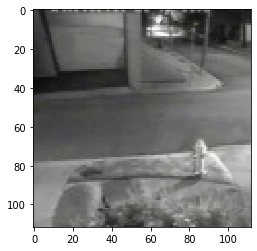

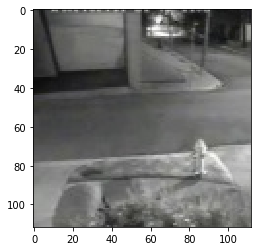

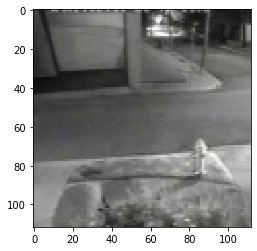

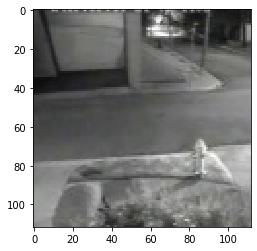

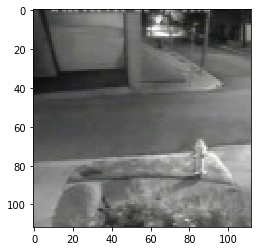

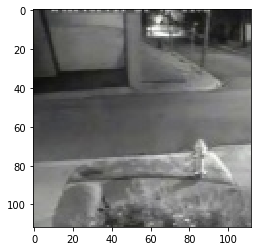

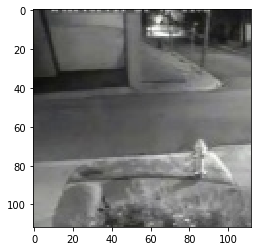

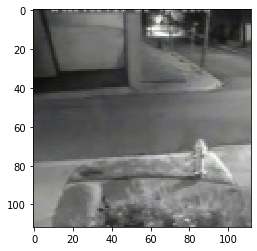

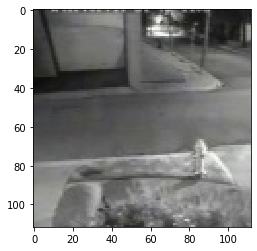

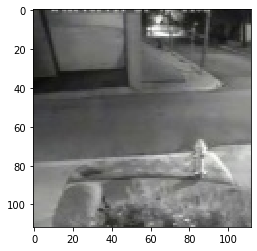

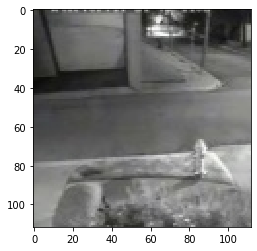

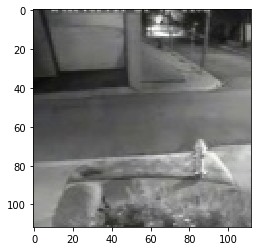

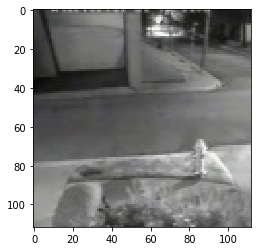

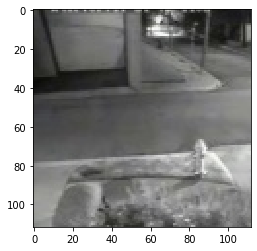

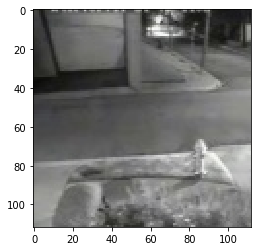

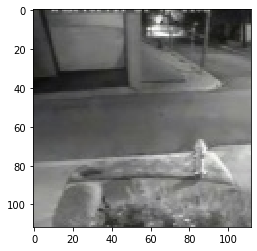

In [126]:
for i, sample in enumerate(trainData_loader):
    inputs = sample[0]
    labels = sample[1]
    
    
    for fr in inputs[3]:
        imgplot = plt.imshow(abs(fr.numpy()))#.astype(np.int64))
        plt.show()
    break